## Self Organizing Map for Mixed Type data

In [52]:
import pandas as pd
import numpy as np
import random
import math
import scipy
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib import animation, colors
from matplotlib.colors import LinearSegmentedColormap

# Helper Functions

In [10]:
# random initialization
def rand_weight(x,y,cr,data):

    # x,y - x*y neurons
    # cr - index of cat features start
    # data - input dataframe


    n = data.shape[0]
    p = data.shape[1]

    random.seed(1123)

    l = []
    

    for j in range(0,x):
        ly = []

        for i in range(0,y):
            w = []

            # for numerical attributes, generate random(0,1)
            for k in range(0,cr):

                w.append(random.uniform(0,1))
            # for categorical attributes, generate probability(0,1)
            for t in range(cr,p):
                # unique values of attribute t
                u_set = data.iloc[:,t].unique()

                dic = {}
                for q in u_set:
                    dic[q] = random.uniform(0,1)

                w.append(dic)

            ly.append(w)
            
        l.append(ly)


    
    
    

    return l


# Distance function
def dissimilarity(X, W, cr):

    # X,W - two list with same size

    n = len(X)

    d_num = 0
    d_cat = 0

    for i in range(0,cr):
         d_num += (X[i] - W[i])**2

    for j in range(cr,n):
        d_cat += (1 - W[j][X[j]])**2

    d = d_num + d_cat

    return d




#find the representation of the winner unit chossing highest probability
def cexp(c,cr,n):
    
    c_exp = c[0:cr]

    for i in range(cr,n):
        c_exp.append(max(c[i], key=c[i].get))

    return c_exp



# eucliean distance
def e_distance(x,y):
  return scipy.spatial.distance.euclidean(x,y)



# sigma function
def sigma(s1,s,T):
    sigma = s1*math.exp(-s/T)
    return sigma





# generate intial weight for each neuron
def init_weight(x,y,cr,p,data):

   

    random.seed(1123)

    l = []
    

    for j in range(0,x):
        ly = []

        for i in range(0,y):
            w = []

            # for numerical attributes, generate random(0,1)
            for k in range(0,cr):

                w.append(0)
            # for categorical attributes, generate probability(0,1)
            for t in range(cr,p):
                # unique values of attribute t
                u_set = data.iloc[:,t].unique()

                dic = {}
                for q in u_set:
                    dic[q] = 0

                w.append(dic)

            ly.append(w)
            
        l.append(ly)
    

    return l


In [27]:
r = rand_weight(3,3,1,df_diag)
print(np.shape(r))
print(r[0][0])
print(r[1][2][7])

i1 = init_weight(5,5,1,df_diag.shape[1],df_diag)

print(i1[1][1])
print(np.shape(i1)) #(5,5,8)


(3, 3, 8)
[0.28015217410863535, {'no': 0.5592678674337969, 'yes': 0.9253661931660643}, {'yes': 0.7694352008829037, 'no': 0.04517379748079786}, {'no': 0.7855735070390756, 'yes': 0.8518051060756764}, {'no': 0.06952934831629032, 'yes': 0.4849808589007607}, {'no': 0.0047835053209099865, 'yes': 0.5900749215763841}, {'no': 0.6815117966622973, 'yes': 0.46255763213380496}, {'no': 0.9575205209152231, 'yes': 0.6919691679079697}]
{'no': 0.16769836228505608, 'yes': 0.5631140034933182}
[0, {'no': 0, 'yes': 0}, {'yes': 0, 'no': 0}, {'no': 0, 'yes': 0}, {'no': 0, 'yes': 0}, {'no': 0, 'yes': 0}, {'no': 0, 'yes': 0}, {'no': 0, 'yes': 0}]
(5, 5, 8)


In [71]:
# test distance function 

list1 = [0,0,0,'b']
list2 = [[[2 for k in range(3)] for j in range(3)] for i in range(3)]


for i in range(0,3):
    for j in range(0,3):
        list2[i][j].append({'a':2,'b':1})

print(list1)               #[0, 0, 0, 'a']
print(list2[0][0])         #[2, 2, 2, {'a': 2, 'b': 1}]
print(list2[0][0][3]['a']) #2


print(dissimilarity(list1,list2[0][0],3))  # 13 = 4 + 4 + 4 + 1
 

[0, 0, 0, 'b']
[2, 2, 2, {'a': 2, 'b': 1}]
2
12


## Training SOM

In [271]:
def train_fmsom(x,
                y,
                data,
                y_label,
                cr,
                s1,
                T,
                nei_fun = None,
                iteration=1000,
                seed = 10):

    # x - x*y neurons
    # y - x*y neurons
    # data - input dataframe
    # cr - number of categorcial attributes
    # s1 - initial radius
    # T - contant for sigma function
    # sigma - radius function
    # dis_fun - distance function
    # nei_fun - neighbourhood function
    # iteration - number of iterations
    # init_weight_fun - initial weight function 


    #result dataframe
    result = data.copy()
    result['winX'] = 'a'#pd.Series()
    result['winY'] = 'b'#pd.Series()



    # P: sample size
    # F: number of attributes
    P, F = np.shape(data)

    # I: number of neurons
    I = x*y

    accumNeighborhood_i = np.zeros((x,y)) 
    numcatWeightUpdates_in_ikc = init_weight(x,y,cr,F,data)
    
    changed = [False]*P

    #intialize 
    weights = rand_weight(x,y,cr,data)


    ##2d som for visuallization####################################################################
    label_data = y_label
    map = np.empty(shape=(x, y), dtype=object)
    for row in range(x):
        for col in range(y):
            map[row][col] = [] # empty list to store the label
    
    label_map = np.zeros(shape=(x, y),dtype=np.int64)
    dis_map = np.zeros(shape=(x, y),dtype=np.int64)
    ################################################################################################



    for t in range(0,iteration):

        print("current iteration: " + str(t))


        # initialize 2d graph for each iteration
        #som2dt.clear()
        #som2dt = map.copy()
        som2dt = np.empty(shape=(x, y), dtype=object)
        for row in range(x):
            for col in range(y):
                som2dt[row][col] = []

        # iterating every data point
        for p in range(0,P):

            x_p = data.loc[p]
            #distMat_x_ij = np.zeros((x,y)) # distance from data point p to 

            winX = 1000
            winY = 1000
            win_dis = 1000000000000
            
            #Competitive Process:
            for i in range(0,x):
                for j in range(0,y):
                    # compute distance from x to neuron ij
                    d = dissimilarity(x_p,weights[i][j],cr)
                    
                    if d < win_dis:
                        #changed = True
                        win_dis = d
                        winX = i 
                        winY = j
            
            if winX != result.loc[p,'winX'] or winY != result.loc[p,'winY']:
                
                result.loc[p,'winX'] = winX
                result.loc[p,'winY'] = winY
                changed[p] = True
    
            
            # update winner unit 2d som ####################################################
            som2dt[winX][winY].append(label_data[p]) 
            ################################################################################


            #Cooperative Process:

            #find the representation of the winner unit chossing highest probability
            #win_unit_exp = cexp(weights[winX][winY],1,F)

            sig = sigma(s1,t,T)
            #print("sigma is "+ str(sig))
            for iii in range(0,x):
                for jjj in range(0,y):
                    d_latticce = e_distance([winX,winY],[iii,jjj])
                    
                    # if the latticce inside the radius of the winner neuron
                    if d_latticce < sig:

                        # compute the gaussian neighbourhood function
                        h = math.exp(-(d_latticce**2)/(2*(sig**2)) )

                        # update the total accumulated neighbourhood of the i,j th n
                        accumNeighborhood_i[iii][jjj] += h


                        # update the accumulated neighbourhood for the numerical feature
                        for n in range(0,cr):
                            numcatWeightUpdates_in_ikc[iii][jjj][n] += h*data.iloc[p,n]
                        
                        # update the accumulated neighbourhood for the catgorical feature
                        for k in range(cr,F):
                            numcatWeightUpdates_in_ikc[iii][jjj][k][data.iloc[p,k]] += h
    
        #Adaptive Process
        for ii in range(0,x):
            for jj in range(0,y):
                if accumNeighborhood_i[ii][jj] > 0:
                    
                    #Update Weight for numerical W
                    for n in range(0,cr):
                        weights[ii][jj][n] = numcatWeightUpdates_in_ikc[ii][jj][n] / accumNeighborhood_i[ii][jj]
                    
                    #update Weight for categorical W
                    for k in range(cr,F):
                        for r in data.iloc[:,k].unique():
                            weights[ii][jj][k][r] = numcatWeightUpdates_in_ikc[ii][jj][k][r] / accumNeighborhood_i[ii][jj]

        #print(changed)

        # #Check Convergence
        if (not any(changed) ):
            
            #########################################################################################
            # magority voting: if a neuron 
            for row in range(0,x):
                for col in range(0,y):
                    label_list = som2dt[row][col]
                    if len(label_list)==0:
                        label = -1
                    else:
                        label = max(label_list, key=label_list.count)
                    label_map[row][col] = label
                    dis_map[row][col] = len(label_list)
            ##########################################################################################





            print("current interation is " + str(t))
            return label_map, result, weights, dis_map
        else:
            accumNeighborhood_i = np.zeros((x,y))
            numcatWeightUpdates_in_ikc = init_weight(x,y,cr,F,data)

            changed = [False]*P




## Diagnosis Data

In [250]:
#read diagnosis data
df_diag = pd.read_csv('D:\STATS4T06\Datasets\diagnosis.csv')


scaler = MinMaxScaler()
df_diag['Column1'] = scaler.fit_transform(df_diag[['Column1']])


trainx_diag = df_diag.iloc[:,0:6]

trainy1_diag = df_diag.loc[:,'Column7']
trainy1_diag = trainy1_diag.map({'yes': 1, 'no': 0})

trainy2_diag = df_diag.loc[:,'Column8']
trainy2_diag = trainy2_diag.map({'yes': 1, 'no': 0})

trainy1_diag


0      0
1      1
2      0
3      1
4      0
      ..
115    0
116    0
117    0
118    0
119    0
Name: Column7, Length: 120, dtype: int64

In [160]:
diag_x = 10
diag_y = 10

diag_map,diag_re,diag_weights,diag_dis = train_fmsom(x=diag_x,y=diag_y,data=trainx_diag,y_label=trainy1_diag ,cr=1,s1=5,T=10,nei_fun = None,iteration=1000,seed = 10)



current interation is 20


In [161]:
diag_dis

array([[ 2,  1,  3,  0,  1,  4,  1,  4,  4,  4],
       [ 3,  0,  0,  0,  2,  3,  0,  0,  0,  2],
       [ 4,  0,  0, 10,  3,  2,  0,  0,  2,  1],
       [ 0,  2,  0,  4,  3,  0,  0,  1,  1,  1],
       [ 3,  0,  0,  0,  1,  0,  1,  1,  1,  0],
       [ 1,  1,  0,  4,  2,  0,  1,  0,  0,  0],
       [ 1,  1,  1,  0,  0,  1,  0,  0,  0,  4],
       [ 1,  1,  1,  0,  1,  0,  4,  0,  0,  0],
       [ 1,  0,  0,  1,  1,  0,  2,  1,  2,  2],
       [ 0,  0,  2,  3,  0,  0,  2,  1,  1,  1]], dtype=int64)

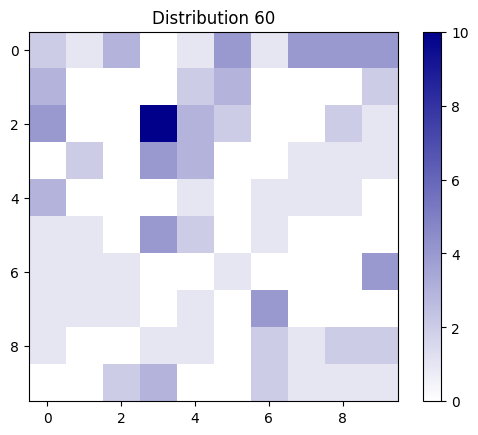

In [162]:
title = ('Distribution ' + str(60))
cmap0 = LinearSegmentedColormap.from_list('', ['white', 'darkblue'])
plt.imshow(diag_dis, cmap=cmap0)
plt.colorbar()
plt.title(title)
plt.show()

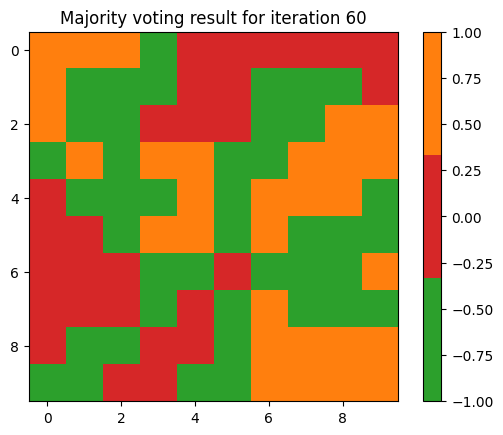

In [163]:
title = ('Majority voting result for iteration ' + str(60))
cmap1 = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange'])
plt.imshow(diag_map, cmap=cmap1)
plt.colorbar()
plt.title(title)
plt.show()

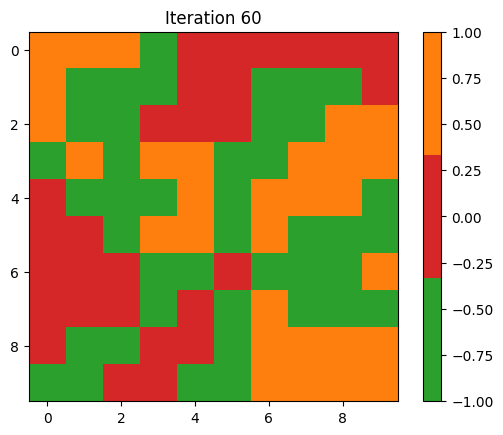

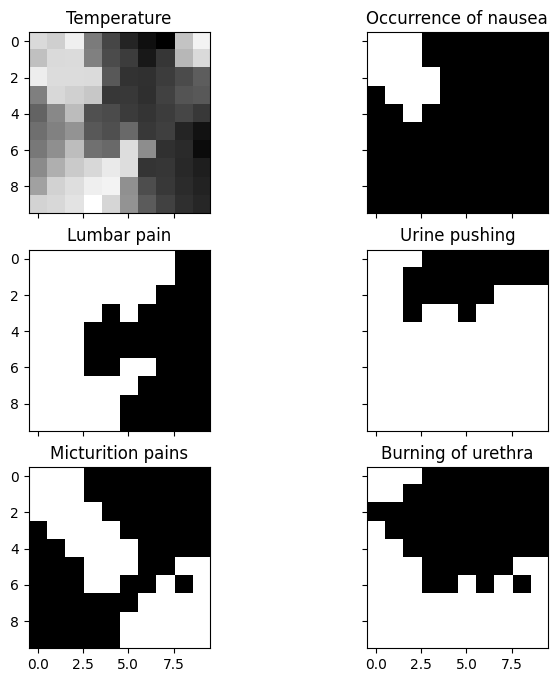

In [164]:
title = ('Iteration ' + str(60))
cmap1 = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange'])
plt.imshow(diag_map, cmap=cmap1)
plt.colorbar()
plt.title(title)
plt.show()

#Tempture map
temp_map = np.zeros(shape=(diag_x, diag_y))
for i in range(0,diag_x):
    for j in range(0,diag_y):
        temp_map[i][j] = diag_weights[i][j][0]

# symptoms1
s1_map = np.zeros(shape=(diag_x, diag_y))
for i in range(0,diag_x):
    for j in range(0,diag_y):
        m = max(diag_weights[i][j][1], key=diag_weights[i][j][1].get)
        if m == 'yes':
            mm = 1
        elif m == 'no':
            mm = 0
        s1_map[i][j] = mm

# symptoms2
s2_map = np.zeros(shape=(diag_x, diag_y))
for i in range(0,diag_x):
    for j in range(0,diag_y):
        m = max(diag_weights[i][j][2], key=diag_weights[i][j][2].get)
        if m == 'yes':
            mm = 1
        elif m == 'no':
            mm = 0
        s2_map[i][j] = mm

# symptoms3
s3_map = np.zeros(shape=(diag_x, diag_y))
for i in range(0,diag_x):
    for j in range(0,diag_y):
        m = max(diag_weights[i][j][3], key=diag_weights[i][j][3].get)
        if m == 'yes':
            mm = 1
        elif m == 'no':
            mm = 0
        s3_map[i][j] = mm

# symptoms4
s4_map = np.zeros(shape=(diag_x, diag_y))
for i in range(0,diag_x):
    for j in range(0,diag_y):
        m = max(diag_weights[i][j][4], key=diag_weights[i][j][4].get)
        if m == 'yes':
            mm = 1
        elif m == 'no':
            mm = 0
        s4_map[i][j] = mm

# symptoms5
s5_map = np.zeros(shape=(diag_x, diag_y))
for i in range(0,diag_x):
    for j in range(0,diag_y):
        m = max(diag_weights[i][j][5], key=diag_weights[i][j  ][5].get)
        if m == 'yes':
            mm = 1
        elif m == 'no':
            mm = 0
        s5_map[i][j] = mm




# title = ('Iteration ' + str(45))
# cmap = plt.cm.gray
# plt.imshow(temp_map, cmap=cmap)
# plt.colorbar()
# plt.title(title)
# plt.show()


fig, axs = plt.subplots(3, 2,figsize=(8,8))

axs[0, 0].imshow(temp_map, cmap=cmap)
axs[0, 0].set_title('Temperature')
axs[0, 1].imshow(s1_map, cmap=cmap)
axs[0, 1].set_title('Occurrence of nausea')
axs[1, 0].imshow(s2_map, cmap=cmap)
axs[1, 0].set_title('Lumbar pain')
axs[1, 1].imshow(s3_map, cmap=cmap)
axs[1, 1].set_title('Urine pushing')
axs[2, 0].imshow(s4_map, cmap=cmap)
axs[2, 0].set_title('Micturition pains')
axs[2, 1].imshow(s5_map, cmap=cmap)
axs[2, 1].set_title('Burning of urethra')

for ax in axs.flat:
    ax.label_outer()

## Drug Data

In [40]:
df_drug = pd.read_csv('D:\STATS4T06\Datasets\drug200.csv')

df_drug = df_drug.iloc[:,[0,4,1,2,3,5]]

scaler = MinMaxScaler()
df_drug['Age'] = scaler.fit_transform(df_drug[['Age']])
df_drug['Na_to_K'] = scaler.fit_transform(df_drug[['Na_to_K']])


trainx_drug = df_drug.iloc[:,0:5]

trainy_drug = df_drug.iloc[:,5]
trainy_drug = trainy_drug.map({'DrugY': 0, 'drugC': 1,'drugX':2,'drugA':3,'drugB':4})


df_drug


,Age,Na_to_K,Sex,BP,Cholesterol,Drug
0,0.135593,0.596848,F,HIGH,HIGH,DrugY
1,0.542373,0.213397,M,LOW,HIGH,drugC
2,0.542373,0.120239,M,LOW,HIGH,drugC
3,0.220339,0.047814,F,NORMAL,HIGH,drugX
4,0.779661,0.368191,F,LOW,HIGH,DrugY
...,...,...,...,...,...,...
195,0.694915,0.165676,F,LOW,HIGH,drugC
196,0.016949,0.179405,M,LOW,HIGH,drugC
197,0.627119,0.113359,M,NORMAL,HIGH,drugX
198,0.135593,0.242385,M,NORMAL,NORMAL,drugX


In [41]:
drug_x = 20
drug_y = 20

drug_map,drug_re,drug_weights,drug_dis  = train_fmsom(x=drug_x,y=drug_y,data=trainx_drug,y_label=trainy_drug ,cr=2,s1=10,T=25,nei_fun = None,iteration=1000,seed = 10)

drug_dis

current interation is 59


array([[ 97,  41,  93,  33,  61,  36,  50,  53, 102,  49,  91,  32,  27,
         19,  64,  56, 111,  43,  32, 106],
       [ 43,  32,   2,  15,  13,  32,   0,  44,  36,  20,   6,  40,   5,
         16,   6,  40,  29,  11,  19,  18],
       [ 47,  30,  21,  19,  18,   7,  20,  26,  39,  15,  32,  13,  24,
          5,  20,  13,  32,  13,  13,  10],
       [ 40,  24,  39,  18,  45,  11,  24,  11,  17,  20,  16,  16,  11,
         14,  12,  18,  12,   7,   8,  32],
       [ 49,   4,  27,  11,   4,  12,  27,  13,  20,  30,  42,   3,  19,
          9,  15,   7,   2,  21,  10,  98],
       [ 65,  19,   4,   5,  23,  48,  30,  10,  15,   0,   0,  12,  12,
         40,  17,   5,  10,  25,  35,  75],
       [173,  20,  18,  60,  22,  17,   7,  25,   7,   9,  35,  13,  62,
         41,  33,   5,   6,  16,  33,  66],
       [ 42,  27,  24,  31,  20,  18,  20,   5,  28,  65,  54,  59,  18,
         37,  20,   8,  24,  30,  23,  36],
       [  8,  29,  18,  39,  28,  25,  20,   5,  70,  67,  30,  

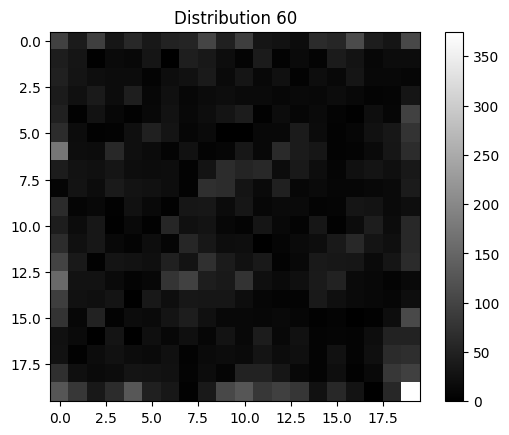

In [42]:
title = ('Distribution ' + str(60))
cmap = plt.cm.gray
plt.imshow(drug_dis, cmap=cmap)
plt.colorbar()
plt.title(title)
plt.show()

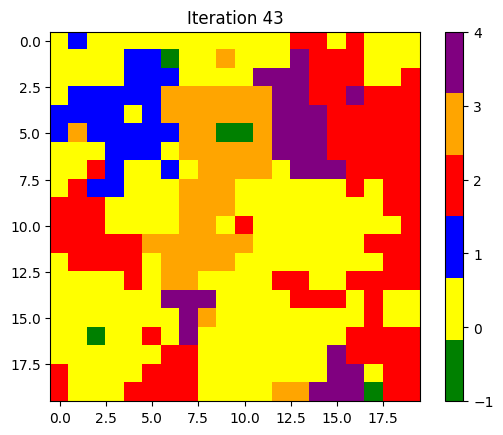

In [243]:
title = ('Iteration ' + str(43))
cmap = colors.ListedColormap(['green','yellow', 'blue','red', 'orange','purple'])
plt.imshow(drug_map, cmap=cmap)
plt.colorbar()
plt.title(title)
plt.show()

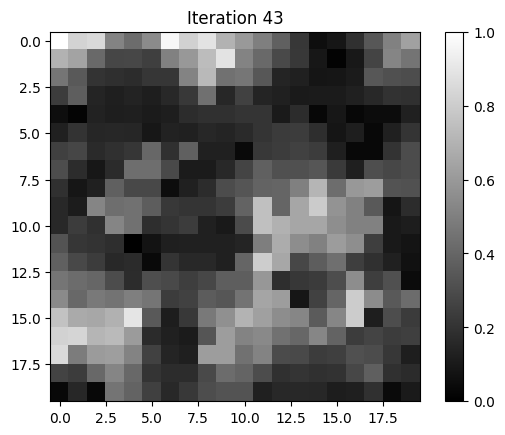

In [244]:
#Na_to_k map
na_map = np.zeros(shape=(drug_x, drug_y))
for i in range(0,drug_x):
    for j in range(0,drug_y):
        na_map[i][j] = drug_weights[i][j][1]
cmap_age = plt.cm.gray
plt.imshow(na_map, cmap=cmap_age)
plt.colorbar()
plt.title(title)
plt.show()

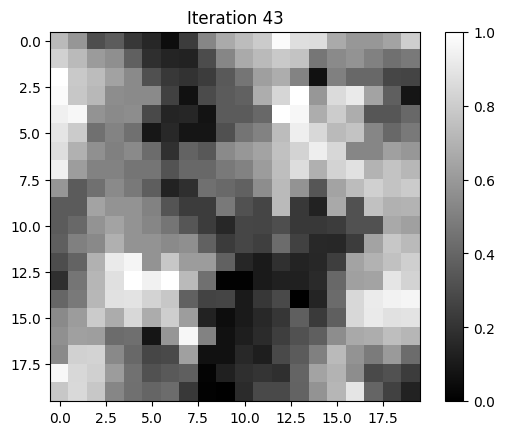

In [245]:
#age map
age_map = np.zeros(shape=(drug_x, drug_y))
for i in range(0,drug_x):
    for j in range(0,drug_y):
        age_map[i][j] = drug_weights[i][j][0]
cmap_age = plt.cm.gray
plt.imshow(age_map, cmap=cmap_age)
plt.colorbar()
plt.title(title)
plt.show()

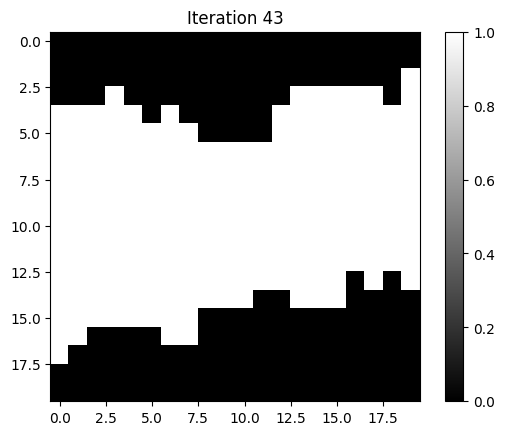

In [246]:
# gender map
g_map = np.zeros(shape=(drug_x, drug_y))
for i in range(0,drug_x):
    for j in range(0,drug_y):
        m = max(drug_weights[i][j][2], key=drug_weights[i][j][2].get)
        if m == 'M':
            mm = 1
        elif m == 'F':
            mm = 0
        g_map[i][j] = mm

plt.imshow(g_map, cmap=cmap_age)
plt.colorbar()
plt.title(title)
plt.show()

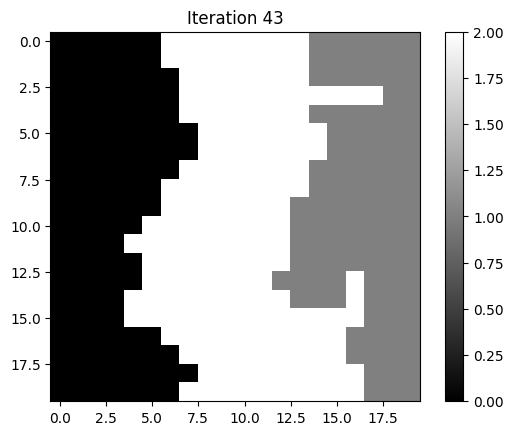

In [247]:
# BP map
bp_map = np.zeros(shape=(drug_x, drug_y))
for i in range(0,drug_x):
    for j in range(0,drug_y):
        m = max(drug_weights[i][j][3], key=drug_weights[i][j][3].get)
        if m == 'HIGH':
            mm = 2
        elif m == 'NORMAL':
            mm = 1
        elif m == 'LOW':
            mm = 0
        bp_map[i][j] = mm

plt.imshow(bp_map, cmap=cmap_age)
plt.colorbar()
plt.title(title)
plt.show()

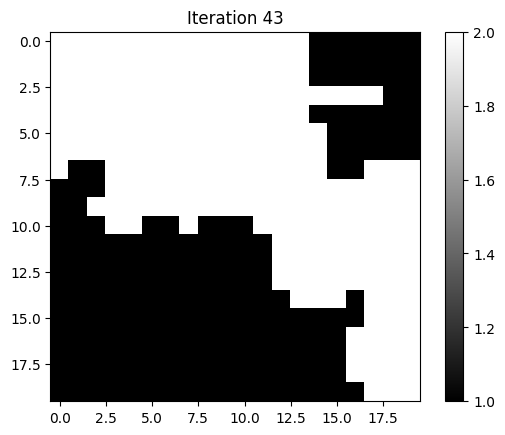

In [252]:
# Cholesterol	 map
cho_map = np.zeros(shape=(drug_x, drug_y))
for i in range(0,drug_x):
    for j in range(0,drug_y):
        m = max(drug_weights[i][j][4], key=drug_weights[i][j][4].get)
        if m == 'HIGH':
            mm = 2
        elif m == 'NORMAL':
            mm = 1
        elif m == 'LOW':
            mm = 0
        cho_map[i][j] = mm

plt.imshow(cho_map, cmap=cmap_age)
plt.colorbar()
plt.title(title)
plt.show()

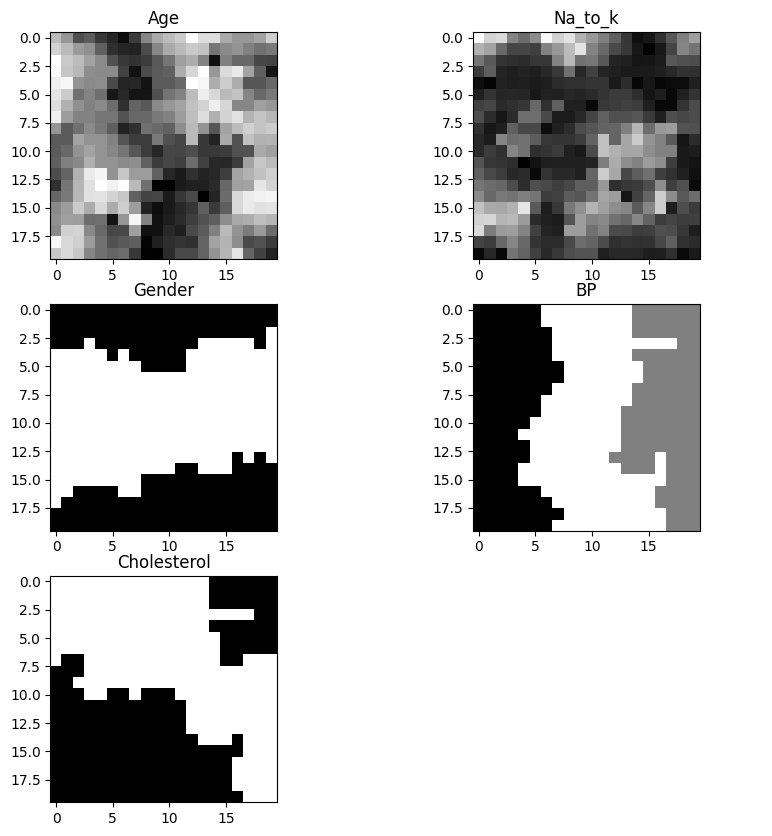

In [256]:
fig1, axs1 = plt.subplots(3, 2,figsize=(10,10))

axs1[0, 0].imshow(age_map, cmap=cmap_age)
axs1[0, 0].set_title('Age')
axs1[0, 1].imshow(na_map, cmap=cmap_age)
axs1[0, 1].set_title('Na_to_k')
axs1[1, 0].imshow(g_map, cmap=cmap_age)
axs1[1, 0].set_title('Gender')
axs1[1, 1].imshow(bp_map, cmap=cmap_age)
axs1[1, 1].set_title('BP')
axs1[2, 0].imshow(cho_map, cmap=cmap_age)
axs1[2, 0].set_title('Cholesterol')
axs1[-1, -1].axis('off')

for ax in axs.flat:
    ax.label_outer()

## Credit Approval Data

In [267]:

df_ca = pd.read_csv("D:\\STATS4T06\\Datasets\\crx.data", delimiter=",",header=None)

df_ca.columns = ['a0', 'a1', 'a2','a3','a4','a5','a6','a7','a8','a9','a10','a11','a12','a13','a14','a15']

df_ca = df_ca.replace("?", np.nan)
df_ca = df_ca.dropna()



df_ca = df_ca.iloc[:,[1,2,7,13,14,3,4,5,6,8,9,10,11,12,15]]
df_ca = df_ca.reset_index()

df_ca['a1'] = df_ca['a1'].astype(float)
df_ca['a2'] = df_ca['a2'].astype(float)
df_ca['a7'] = df_ca['a7'].astype(float)
df_ca['a13'] = df_ca['a13'].astype(float)
df_ca['a14'] = df_ca['a14'].astype(float)

scaler = MinMaxScaler()
df_ca['a1'] = scaler.fit_transform(df_ca[['a1']])
df_ca['a2'] = scaler.fit_transform(df_ca[['a2']])
df_ca['a7'] = scaler.fit_transform(df_ca[['a7']])
df_ca['a13'] = scaler.fit_transform(df_ca[['a13']])
df_ca['a14'] = scaler.fit_transform(df_ca[['a14']])



trainx_ca = df_ca.iloc[:,1:14]


trainy_ca = df_ca.iloc[:,15].map({'+': 1, '-': 0})


trainy_ca


0      1
1      1
2      1
3      1
4      1
      ..
648    0
649    0
650    0
651    0
652    0
Name: a15, Length: 653, dtype: int64

In [268]:
ca_x = 15
ca_y = 15

ca_map,ca_re,ca_weights,ca_dis  = train_fmsom(x=ca_x,y=ca_y,data=trainx_ca,y_label=trainy_ca ,cr=5,s1=10,T=25,nei_fun = None,iteration=1000,seed = 10)

ca_dis

current interation is 61


array([[16,  0,  8,  0, 17,  0,  5,  5,  7,  3,  3,  0,  6,  0,  7],
       [ 0,  3,  0,  3,  0,  3,  0,  0,  0,  0,  6,  4,  0,  6,  0],
       [ 0,  4,  1,  0,  4,  0,  0,  0,  0,  0,  4,  7,  0,  1,  1],
       [ 3,  3,  2,  0,  2,  3,  2,  4,  6,  0,  1,  5,  0,  0,  6],
       [ 2,  5,  0,  6,  1,  7,  6,  1,  0,  4,  0,  2,  0,  4,  0],
       [ 4,  0,  9,  0,  0,  0,  1,  0,  3,  0,  4,  0,  3,  0,  3],
       [ 0,  4,  0,  0,  5,  0,  0,  4,  0,  5,  0,  2,  0,  0,  4],
       [10,  0,  0,  0,  6,  3,  7,  0,  2,  3,  0,  7,  0,  2,  8],
       [ 1,  4, 13,  1,  4,  0,  0,  2,  3,  1,  4,  2,  1,  0,  9],
       [ 4,  5,  0,  5,  0,  0,  1,  3,  0,  2,  0,  7,  0,  4,  0],
       [ 7,  0,  7,  0, 10,  4,  6,  5,  3,  3,  1,  3,  0,  1,  0],
       [ 1,  2,  4,  1,  0,  0,  4,  4,  0,  6,  0,  3,  7,  0, 16],
       [ 7,  0,  7,  7,  3,  8,  0,  1,  3,  0,  9,  6,  0,  0, 10],
       [ 0,  6,  0,  8,  1,  1,  1,  1,  0,  0,  5,  6,  0,  0, 11],
       [ 7,  0, 11,  5,  3, 11,  0

In [272]:
ca_x = 10
ca_y = 10

ca_map1,ca_re1,ca_weights1,ca_dis1  = train_fmsom(x=ca_x,y=ca_y,data=trainx_ca,y_label=trainy_ca ,cr=5,s1=5,T=10,nei_fun = None,iteration=1000,seed = 10)

ca_dis1

current iteration: 0
current iteration: 1
current iteration: 2
current iteration: 3
current iteration: 4
current iteration: 5
current iteration: 6
current iteration: 7
current iteration: 8
current iteration: 9
current iteration: 10
current iteration: 11
current iteration: 12
current iteration: 13
current iteration: 14
current iteration: 15
current iteration: 16
current iteration: 17
current iteration: 18
current iteration: 19
current iteration: 20
current iteration: 21
current interation is 21


array([[15,  0, 14,  5,  0, 16,  0, 21,  0, 19],
       [ 0, 13,  0,  2, 13,  0,  9,  0,  8,  0],
       [21,  0,  3,  7,  0, 11,  0,  5,  1,  5],
       [ 6,  0, 12,  0, 11,  0,  5,  6,  0,  9],
       [27,  0,  0,  8,  0,  7,  3,  0,  4,  0],
       [20,  0,  7,  0, 12,  3,  0,  8,  0, 11],
       [22,  0,  4, 15,  0, 10,  5,  2,  7,  4],
       [11,  2, 20,  0, 13, 11, 11,  9,  3, 30],
       [ 2, 13,  6,  3,  0,  0,  6,  3,  6,  0],
       [21,  0, 11,  8,  4,  5,  7, 11,  5, 16]], dtype=int64)

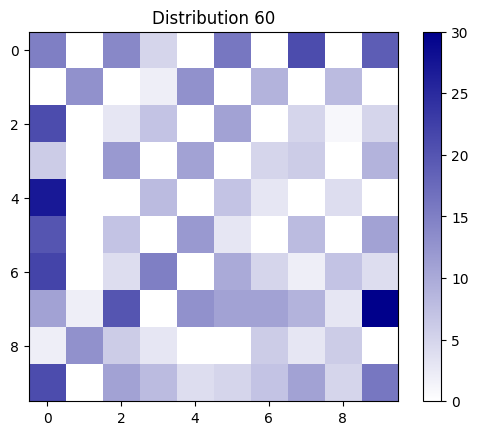

In [273]:
title = ('Distribution ' + str(60))
cmap0 = LinearSegmentedColormap.from_list('', ['white', 'darkblue'])
plt.imshow(ca_dis1, cmap=cmap0)
plt.colorbar()
plt.title(title)
plt.show()

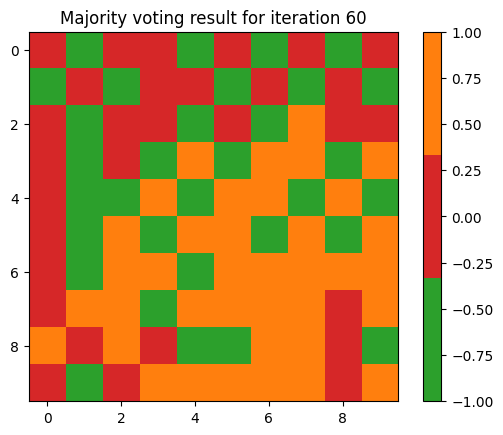

In [274]:
title = ('Majority voting result for iteration ' + str(60))
cmap1 = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange'])
plt.imshow(ca_map1, cmap=cmap1)
plt.colorbar()
plt.title(title)
plt.show()